In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_sequence
import onnx

from model_model import SiameseNetwork
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp

In [2]:
dimconf = ModelDimConfigs(
        rnn_in_size=64, 
        lin_in_size_1=32, 
        lin_in_size_2=16, 
        lin_out_size_2=1
    )

model = SiameseNetwork(
    dimconf=dimconf
)

In [3]:
model

SiameseNetwork(
  (rnn): SelfPackLSTM(
    (rnn): LSTM(64, 32, num_layers=2, batch_first=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [6]:
x1 = torch.rand(3, 20, 64)
x2 = torch.rand(3, 12, 64)

l1 = torch.randint(1, 20, (3, ))
l2 = torch.randint(1, 12, (3, ))

In [7]:
o = model((x1, x2), (l1, l2))

In [8]:
onnx_path = "save.onnx"
torch.onnx.export(model, ((x1, x2), (l1, l2)), onnx_path)

In [3]:
torch.save(model.state_dict(), "save.pth")

In [49]:
x = torch.randn(3, 4, 5)
x_lens = torch.tensor([1, 2, 4])

In [51]:
torch.nn.functional.one_hot(x_lens - 1)

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])

In [44]:
nx = x[, :]

In [45]:
nx.shape

torch.Size([3, 3, 4, 5])

In [55]:
torch.index_select(x, 1, x_lens - 1).shape

torch.Size([3, 3, 5])

In [28]:
import time
import pylab as pl
from IPython import display
import time
import random
import matplotlib.pylab as plt
from IPython import display

In [42]:
def draw_learning_curve_and_accuracy(losses, accs, epoch=""): 
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    train_losses, valid_losses, best_val_loss = losses
    valid_accs = accs

    # Plot Loss on the left subplot
    ax1.plot(train_losses, label='Train')
    ax1.plot(valid_losses, label='Valid')
    ax1.axvline(x=best_val_loss, color='r', linestyle='--', label="Best: " + str(best_val_loss))
    ax1.set_title("Learning Curve Loss" + f" {epoch}")
    ax1.legend(loc="upper right")

    # Plot Accuracy on the right subplot
    ax2.plot(valid_accs, label='Valid')
    ax2.set_title('Learning Curve Accuracy' + f" {epoch}")
    ax2.legend(loc="lower right")

    # Display the plots
    plt.tight_layout()
    plt.xlabel("Epoch")
    display.clear_output(wait=True)
    display.display(plt.gcf())

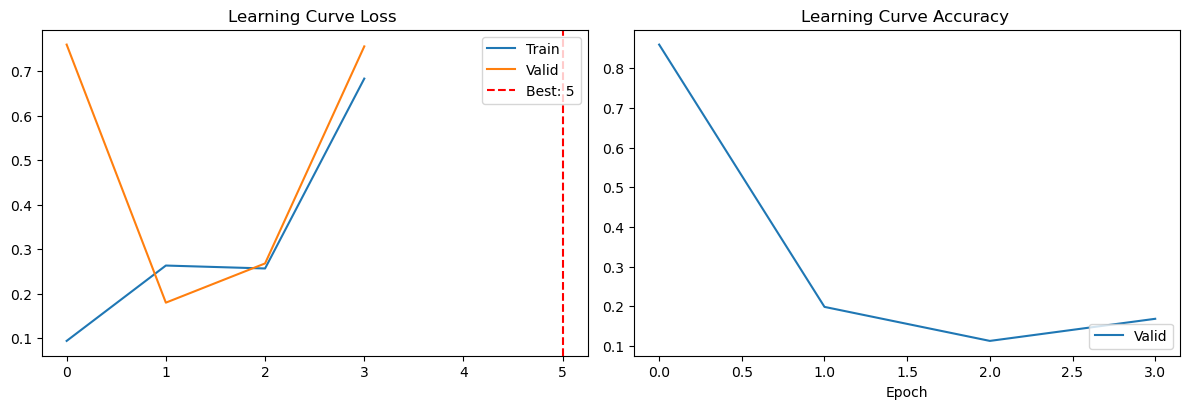

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

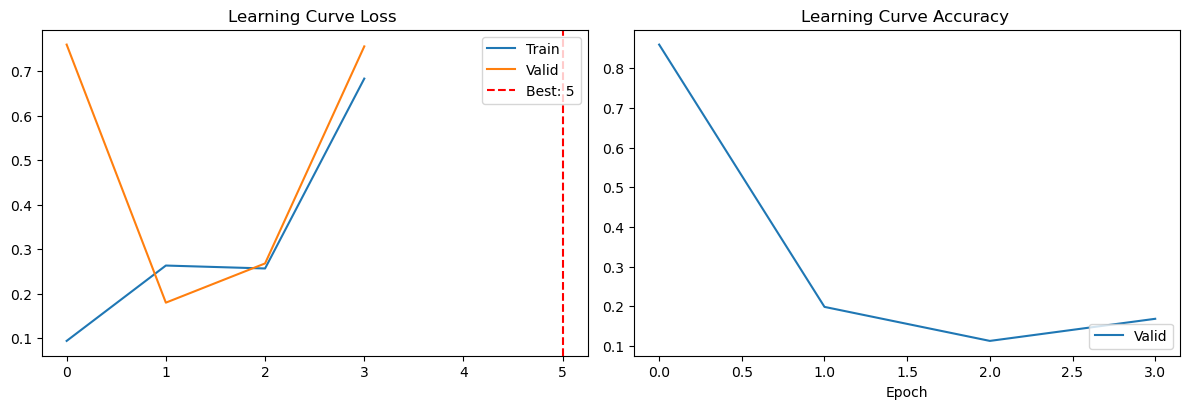

In [43]:
train_losses = []
valid_losses = []

valid_accs = []

while True:
    try:

        train_losses.append(random.random())
        valid_losses.append(random.random())

        valid_accs.append(random.random())

        draw_learning_curve_and_accuracy((train_losses, valid_losses, 5), (valid_accs))
        time.sleep(1)
    except KeyboardInterrupt:
        break

In [1]:
import pandas as pd
import os
from paths import *

In [2]:
guide_file = pd.read_csv(os.path.join(src_, "guide_mod.csv"))

In [3]:
guide_file["segment_nostress"].unique().tolist()

['sil',
 'CH',
 'AE',
 'P',
 'T',
 'ER',
 'W',
 'AH',
 'N',
 'sp',
 'M',
 'IH',
 'S',
 'Z',
 'R',
 'EY',
 'L',
 'D',
 'AY',
 'V',
 'JH',
 'EH',
 'DH',
 'IY',
 'OW',
 'AW',
 'UW',
 'HH',
 'AA',
 'F',
 'TH',
 'AO',
 'B',
 'UH',
 'K',
 'Y',
 'NG',
 'G',
 'SH',
 'OY',
 'ZH',
 'spn']

In [8]:
import torch.nn as nn
import torch

In [18]:
sm = nn.Softmax(dim=1)

In [19]:
x = torch.randn(size=(5, 10))

In [20]:
x

tensor([[ 0.8863,  0.1093,  0.9341, -0.7400, -0.1759,  0.4170, -0.6253, -2.1953,
          1.7105, -1.3972],
        [-1.6566,  0.4989, -0.8215, -0.7731,  0.8442, -0.2636, -0.2400, -0.9204,
          0.3180, -0.7191],
        [ 2.0954, -1.9509,  1.6724, -0.5004,  0.2676,  1.0348, -0.5430,  0.6520,
         -0.1656,  0.6663],
        [-1.2439, -0.4518, -1.4087,  1.8685,  1.9991, -0.5235,  0.5470, -1.0004,
          0.2612,  0.4925],
        [-0.9078, -0.1602,  0.6646,  0.0174,  1.4603, -0.3822, -0.6509, -1.3161,
          0.6787,  0.1360]])

In [22]:
y = sm(x)

In [27]:
torch.argmax(y, dim=1)

tensor([8, 4, 0, 4, 4])

In [ ]:
# data = {'type': ds.seg_set}
# counts = pd.DataFrame(data)["type"].value_counts()
# # Create a bar graph for vowels
# plt.figure(figsize=(15, 4))
# plt.bar(counts.index, counts.values, color='skyblue')
# plt.xlabel('Phones')
# plt.ylabel('Count')
# plt.title('Count of Phones - Dataset')
# plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# # Display the bar graph
# plt.show()


# data = {'type': ds.seg_set}
# counts = pd.DataFrame(data)["type"][train_ds.indices].value_counts()
# # Create a bar graph for vowels
# plt.figure(figsize=(15, 4))
# plt.bar(counts.index, counts.values, color='skyblue')
# plt.xlabel('Phones')
# plt.ylabel('Count')
# plt.title('Count of Phones - Trainset')
# plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# # Display the bar graph
# plt.show()


# data = {'type': ds.seg_set}
# counts = pd.DataFrame(data)["type"][valid_ds.indices].value_counts()
# # Create a bar graph for vowels
# plt.figure(figsize=(15, 4))
# plt.bar(counts.index, counts.values, color='skyblue')
# plt.xlabel('Phones')
# plt.ylabel('Count')
# plt.title('Count of Phones - Validset')
# plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# # Display the bar graph
# plt.show()